In [1]:
%%bash

pip install getgist
getgist lambdaofgod github_topic_modeling_packages.sh
bash github_topic_modeling_packages.sh

  Fetching https://api.github.com/users/lambdaofgod/gists
  Reading https://gist.githubusercontent.com/lambdaofgod/c32ab43cecce4219a697376f3dda3866/raw/689cf570db88e3a951821624fd652c2342efa755/github_topic_modeling_packages.sh
Overwrite existing github_topic_modeling_packages.sh? (y/n)  [y/N]: Error: invalid input
Overwrite existing github_topic_modeling_packages.sh? (y/n)  [y/N]: 

You should consider upgrading via the 'pip install --upgrade pip' command.
Aborted!


In [2]:
import os

import re
import tqdm
import requests

import numpy as np

from bs4 import BeautifulSoup
from markdown import markdown


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold, pipeline
from sklearn.feature_extraction import stop_words
from sklearn import pipeline
 

from mlutil import topic_modeling

import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import scipy.stats

/home/kuba/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
plt.style.use('dark_background')

In [4]:
def printmd(string):
    display(Markdown(string))

In [5]:
if os.path.exists('github_auth_key.txt'):
    token = open('github_auth_key.txt').read().rstrip()
    headers = {'Authorization': 'token %s' % token}
else:
    token = ''
    headers = {}

In [6]:
def search_repositories(query, pages=10):
    i = 1
    url = 'https://api.github.com/search/repositories?q={}&page={}&per_page=100'
    starred_response = []
    tmp_response = requests.get(url.format(query, i), headers={**headers, "Accept": "application/vnd.github.mercy-preview+json"})
    while tmp_response.ok and i <= pages:
        starred_response = starred_response + tmp_response.json()['items']
        i += 1
        tmp_response = requests.get(url.format(query, i), headers={**headers, "Accept": "application/vnd.github.mercy-preview+json"})

    print(tmp_response.json())
    if len(starred_response) == 0:
        raise requests.HTTPError('Error occured while fetching, most likely you went over rate limit')
    else:
        return starred_response

In [7]:
def get_cleaned_repositories_df(repo_information):
    repo_df = json_normalize(repo_information)
    repo_df = repo_df.drop_duplicates(subset=['name'])
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['topics'] = repo_df['topics'].apply(' '.join)
    repo_df['description'] = repo_df['description'].fillna('')
    return repo_df


def get_word_cloud(texts):
    text = ' '.join(texts)
    return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
    plt.figure(**figure_kwargs)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

  
def show_word_cloud_from_texts(text_column):
    texts = text_column.fillna('').values
    cloud = get_word_cloud(texts)
    show_word_cloud(cloud)


def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [8]:
topics = ['machine-learning', 'nlp', 'text-mining']

In [9]:
%%time
ml_repos = search_repositories('topic:machine-learning')

{'message': 'Only the first 1000 search results are available', 'documentation_url': 'https://developer.github.com/v3/search/'}
CPU times: user 478 ms, sys: 53.8 ms, total: 532 ms
Wall time: 24.4 s


In [10]:
len(ml_repos)

1000

In [11]:
%%time
tm_repos = search_repositories('topic:text-mining')

{'message': 'Only the first 1000 search results are available', 'documentation_url': 'https://developer.github.com/v3/search/'}
CPU times: user 497 ms, sys: 20.9 ms, total: 518 ms
Wall time: 21.4 s


In [12]:
len(tm_repos)

868

In [13]:
%%time
nlp_repos = search_repositories('topic:nlp')

{'message': 'Only the first 1000 search results are available', 'documentation_url': 'https://developer.github.com/v3/search/'}
CPU times: user 495 ms, sys: 39.1 ms, total: 534 ms
Wall time: 24.7 s


In [14]:
len(nlp_repos)

1000

In [15]:
repo_df = get_cleaned_repositories_df(ml_repos + nlp_repos + tm_repos)

In [16]:
repo_df['description_keywords'] = repo_df['description'].apply(summarization.keywords)

Primary language

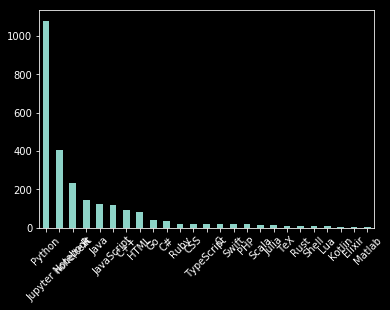

In [17]:
repo_df['language'].fillna('none/text').value_counts()[:25].plot.bar(rot=45);

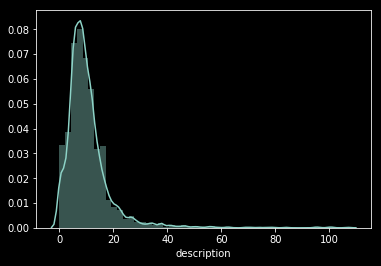

In [18]:
sns.distplot(repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l)));

Topics word cloud

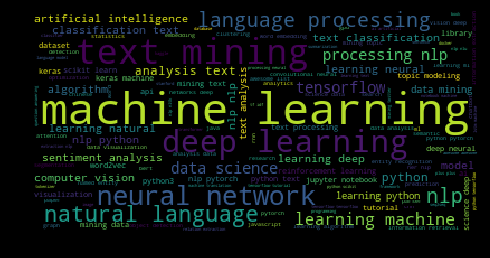

In [19]:
show_word_cloud_from_texts(repo_df['topics'])

Descriptions word cloud

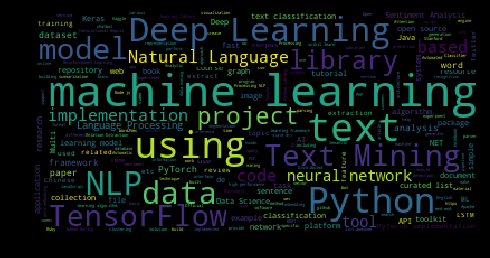

In [20]:
show_word_cloud_from_texts(repo_df['description'])

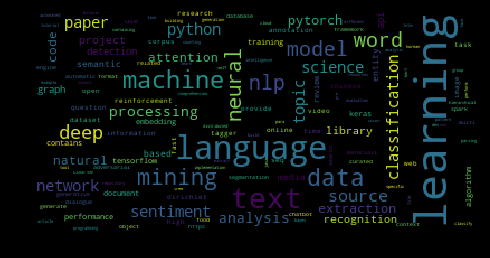

In [21]:
show_word_cloud_from_texts(repo_df['description_keywords'])

## Topic modeling (repo descriptions)

In [62]:
num_topics = 25

topic_modeler = decomposition.NMF(n_components=num_topics, alpha=0.01, l1_ratio=0.5)

In [63]:
deduped_repo_df = repo_df.drop_duplicates()

In [64]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words.ENGLISH_STOP_WORDS,
    ngram_range=(1,2),
    max_features=2500
)
description_vectors = vectorizer.fit_transform(repo_df['description'])

In [65]:
description_vectors.shape

(2623, 2500)

In [66]:
reduced_description_vectors = topic_modeler.fit_transform(description_vectors)

In [67]:
topic_words = topic_modeling.top_topic_words(topic_modeler, vectorizer.get_feature_names(), 10)

In [68]:
top_words_per_topic = [list(topic_words.iloc[topic].values) for topic in range(num_topics)]
representative_repos = [get_repos_representing_topic(repo_df, reduced_description_vectors, topic)[['description']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

In [69]:
for topic in range(num_topics):
    printmd('## **topic {} keywords:**'.format(topic + 1))
    display(top_words_per_topic[topic])
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

## **topic 1 keywords:**

['machine learning',
 'machine',
 'learning',
 'algorithms',
 'learning library',
 'learning models',
 'resources',
 'learning algorithms',
 'repository',
 'learning machine']

## **repositories representative for 1th topic:**

,description
name,
ml-cheatsheet,Machine learning cheatsheet
mlr,mlr: Machine Learning in R
ml-interview,Preparing for machine learning interviews
nilearn,Machine learning for NeuroImaging in Python
learn-machine-learning-in-two-months,Những kiến thức cần thiết để học tốt Machine L...


## **topic 2 keywords:**

['language',
 'natural',
 'natural language',
 'language processing',
 'processing',
 'processing nlp',
 'parser',
 'detection',
 'language detection',
 'javascript']

## **repositories representative for 2th topic:**

,description
name,
NaturalLanguageProcessing,Natural Language Procesing
NLP-Papers,Natural Language Processing Papers
compromise,modest natural-language processing in javascript
deep-NLP,from kaggle natural language processing
hubot-natural,Natural Language Processing Chatbot for Rocket...


## **topic 3 keywords:**

['mining',
 'text mining',
 'text',
 'mining python',
 'analysis text',
 'crossref',
 'mining project',
 'short text',
 'data mining',
 'short']

## **repositories representative for 3th topic:**

,description
name,
Class-13-text-mining,Predavanja 13: Text Mining
textmining3,Text Mining Utilities for Python 3
TextMining,Python文本挖掘系统 Research of Text Mining System
R.TeMiS,R.TeMiS: R Text Mining Solution
Woolly,The Text Mining Elixir


## **topic 4 keywords:**

['deep',
 'deep learning',
 'learning',
 'reinforcement learning',
 'reinforcement',
 'learning deep',
 'framework',
 'learning framework',
 'deep reinforcement',
 'papers']

## **repositories representative for 4th topic:**

,description
name,
grenade,Deep Learning in Haskell
dlcampjeju,Deep Learning Camp Jeju
ConvNetSharp,Deep Learning in C#
DeepAudioClassification,Finding the genre of a song with Deep Learning
DLInterview,Deep Learning Interview 深度学习面试题目汇总


## **topic 5 keywords:**

['network',
 'neural network',
 'neural',
 'convolutional',
 'convolutional neural',
 'based',
 'keras',
 'artificial neural',
 'toolkit',
 'artificial']

## **repositories representative for 5th topic:**

,description
name,
onnx,Open Neural Network Exchange
NeuralNetwork,"Network of neural | SLP, MLP"
python_autocomplete,A simple neural network for python autocompletion
myIR,IR System with Neural Network
layer,Neural network inference the Unix way


## **topic 6 keywords:**

['data',
 'science',
 'data science',
 'data mining',
 'text data',
 'data analysis',
 'course',
 'projects',
 'science projects',
 'analysis']

## **repositories representative for 6th topic:**

,description
name,
Simon_Data-Science,Simon's Data Science Fantasy
jstor,Import journal data from DfR (JSTOR)
Data-Science-,For the data science/data analysis
Virgilio,Your new Mentor for Data Science E-Learning.
Text-classification-sarcastic-or-not,Text mining and Data Science applications on t...


## **topic 7 keywords:**

['python',
 'python library',
 'python implementation',
 'package',
 'learning python',
 'python package',
 'wrapper',
 'api',
 'nlp python',
 'python wrapper']

## **repositories representative for 7th topic:**

,description
name,
PersianStemmer-Python,PersianStemmer-Python
mne-python,MNE : Magnetoencephalography (MEG) and Electro...
pymetamap,Python wraper for MetaMap
mit-ml,斯坦福机器学习完整 python 实现
machine-learning-python,機器學習: Python


## **topic 8 keywords:**

['analysis',
 'sentiment',
 'sentiment analysis',
 'twitter',
 'tweets',
 'text analysis',
 'analysis text',
 'analysis tweets',
 'package',
 'reviews']

## **repositories representative for 8th topic:**

,description
name,
rap_album_sentiment_analysis,Sentiment analysis on rap albums in R
kesci-urdu-sentiment-analysis,sentiment-analysis
sentR,Robust sentiment analysis package for R
Sentiment-Analysis-Twitter-Data,In this Repository I have attached the file fo...
SA-papers,📄 Deep Learning 中 Sentiment Analysis 論文統整與分析 😀...


## **topic 9 keywords:**

['nlp',
 'spacy',
 'processing nlp',
 'deep nlp',
 'nlp tasks',
 'course',
 'nlp python',
 'tasks',
 'nlp library',
 'simple']

## **repositories representative for 9th topic:**

,description
name,
learning-nlp,nlp in action
NLP-OSS,Democratizing NLP!
NlpMindmap,建立你的自然语言处理地图：学习笔记，资源，代码分享；NLP 算法工程师：从小白到专家
text,Data loaders and abstractions for text and NLP
gluon-nlp,NLP made easy


## **topic 10 keywords:**

['tensorflow',
 'tensorflow implementation',
 'tutorials',
 'implemented tensorflow',
 'implemented',
 'api',
 'net',
 'keras',
 'examples',
 'implementation']

## **repositories representative for 10th topic:**

,description
name,
tensorflow-docs,TensorFlow 最新官方文档中文版
CipherGAN,TensorFlow implementation of CipherGAN
im2latex,Tensorflow Implementation of Im2Latex
tensorfow-rbm,Tensorflow implementation of Restricted Boltzm...
learning-to-learn,Learning to Learn in TensorFlow


## **topic 11 keywords:**

['list',
 'curated',
 'curated list',
 'resources',
 'awesome',
 'list awesome',
 'papers',
 'list resources',
 'tutorials',
 'libraries']

## **repositories representative for 11th topic:**

,description
name,
awesome-machine-learning-interpretability,A curated list of awesome machine learning int...
awesome-awesome,A curated list of awesome curated lists of man...
Awesome-Chinese-NLP,A curated list of resources for Chinese NLP 中文...
awesome-anomaly-detection,A curated list of awesome anomaly detection re...
beginner_nlp,A curated list of beginner resources in Natura...


## **topic 12 keywords:**

['classification',
 'text',
 'text classification',
 'classification models',
 'keras',
 'bert',
 'library keras',
 'toolkit',
 'multilabel',
 'vietnamese']

## **repositories representative for 12th topic:**

,description
name,
text_classifier,Text Classification in Python and in R
classification,Vietnamese Text Classification
text-classifier,text-classifier is a toolkit for text classifi...
Caver,Caver: a toolkit for multilabel text classific...
text-classification-keras,📚 Text Classification Library with Keras


## **topic 13 keywords:**

['open',
 'source',
 'open source',
 'framework',
 'learning framework',
 'source machine',
 'platform',
 'net',
 'platform machine',
 'tool']

## **repositories representative for 13th topic:**

,description
name,
claf,CLaF: Open-Source Clova Language Framework
tensorflow,An Open Source Machine Learning Framework for ...
docluster,Open Source NLP Library
tensorflow-internals,It is open source ebook about TensorFlow kerne...
mlflow,Open source platform for the machine learning ...


## **topic 14 keywords:**

['library',
 'learning library',
 'python library',
 'java',
 'nlp library',
 'simple',
 'lightweight',
 'text',
 'php',
 'node']

## **repositories representative for 14th topic:**

,description
name,
pyphonetics,A Python 3 phonetics library.
clfzoo,A deep text classifiers library.
cuml,cuML - RAPIDS Machine Learning Library
fuku-ml,Simple machine learning library / 簡單易用的機器學習套件
mordecai,Full text geoparsing as a Python library


## **topic 15 keywords:**

['project',
 'course',
 'project based',
 'page',
 'mining project',
 'final project',
 'final',
 'school',
 'materials',
 'based']

## **repositories representative for 15th topic:**

,description
name,
Quote-Attribution,CS1049 - Minor Project
zuerich_speaks,TWIST2018 Project
recipe-analyzer,Project for the Project Tools BSc course at ELTE.
FlirtAnalyzer,This project is my senior project and I build ...
FutureTDM,Materials of FutureTDM project


## **topic 16 keywords:**

['implementation',
 'pytorch',
 'pytorch implementation',
 'tensorflow implementation',
 'model',
 'python implementation',
 'paper',
 'attention',
 'algorithm',
 'nips']

## **repositories representative for 16th topic:**

,description
name,
deeplabv3,"PyTorch implementation of DeepLabV3, trained o..."
QANet-pytorch-,A Pytorch implementation of QANet
BERT-pytorch,Google AI 2018 BERT pytorch implementation
attention-is-all-you-need-pytorch,A PyTorch implementation of the Transformer mo...
pytorch-handbook,pytorch handbook是一本开源的书籍，目标是帮助那些希望和使用PyTorch进行...


## **topic 17 keywords:**

['extraction',
 'relation',
 'relation extraction',
 'information',
 'information extraction',
 'open information',
 'retrieval',
 'automatic',
 'based',
 'supervised']

## **repositories representative for 17th topic:**

,description
name,
Chinese-relation-extraction,Relation Extraction 中文关系提取
Open-IE-Papers,Open Information Extraction (OpenIE) and Open ...
zhopenie,Chinese Open Information Extraction (Tree-base...
VERSE,Vancouver Event and Relation System for Extrac...
kg-baseline-pytorch,2019百度的关系抽取比赛，使用Pytorch实现苏神的模型，F1在dev集可达到0.75，...


## **topic 18 keywords:**

['code',
 'repository',
 'paper',
 'book',
 'code paper',
 'source code',
 '2017',
 'python code',
 'contains',
 'repository contains']

## **repositories representative for 18th topic:**

,description
name,
JData,京东JData算法大赛-高潜用户购买意向预测入门程序(starter code)
ml_code,A repository for recording the machine learnin...
TsetlinMachine,The code and datasets for the Tsetlin Machine
bellarmine_py_intro,Code and materials for Python intro. course.
deep-semantic-code-search,Deep Semantic Code Search aims to explore a jo...


## **topic 19 keywords:**

['using',
 'prediction',
 'algorithm',
 'using machine',
 'using python',
 'tool',
 'word2vec',
 'java',
 'similarity',
 'search']

## **repositories representative for 19th topic:**

,description
name,
Wineinformatics,Regional Wine Prediction using KNN and Similar...
Evolutionary-Algorithm,Evolutionary Algorithm using Python
PyKOMORAN,(Beta) PyKOMORAN is wrapped KOMORAN in Python ...
BibSample,Eample of using dataset api in tensorflow
spacy-vis,A visualisation tool for Spacy using Hierplane.


## **topic 20 keywords:**

['learn',
 'scikit learn',
 'scikit',
 'notebooks',
 'jupyter',
 'api',
 'jupyter notebooks',
 'spark',
 'learning python',
 'book']

## **repositories representative for 20th topic:**

,description
name,
sparkit-learn,PySpark + Scikit-learn = Sparkit-learn
scikit-survival,Survival analysis built on top of scikit-learn
ScikitLearn.jl,Julia implementation of the scikit-learn API
scikit-learn-doc-zh,:book: [译] scikit-learn（sklearn） 中文文档
scikit-learn,scikit-learn: machine learning in Python


## **topic 21 keywords:**

['networks',
 'neural networks',
 'neural',
 'convolutional',
 'convolutional neural',
 'images',
 'networks pytorch',
 'convolutional networks',
 'deep neural',
 'generative']

## **repositories representative for 21th topic:**

,description
name,
bindsnet,Simulation of spiking neural networks (SNNs) u...
troll,Language sentiment analysis and neural network...
vision_networks,Repo about neural networks for images handling
cat-generator,Generate cat images with neural networks
DeepLearning.scala,A simple library for creating complex neural n...


## **topic 22 keywords:**

['models',
 'learning models',
 'ml',
 'training',
 'high',
 'performance',
 'high performance',
 'ml models',
 'datasets',
 'spacy']

## **repositories representative for 22th topic:**

,description
name,
modeldb,A system to manage machine learning models
interpretable_machine_learning_with_python,Practical techniques for training interpretabl...
serving,"A flexible, high-performance serving system fo..."
model-zoo,Please do not feed the models
cortex,Deploy machine learning models to production


## **topic 23 keywords:**

['ai',
 'research',
 'js',
 'node',
 'node js',
 'platform',
 'conversational',
 'based',
 'google',
 'conversational ai']

## **repositories representative for 23th topic:**

,description
name,
ai-deadlines,:alarm_clock: AI conference deadline countdowns
google-research,Google AI Research
lab,A customisable 3D platform for agent-based AI ...
openfoodfacts-ai,"This is to track all our AI endeavours, and wi..."
fastai-ml-dl-notes-zh,:book: [译] fast.ai 机器学习和深度学习中文笔记


## **topic 24 keywords:**

['word',
 'embeddings',
 'word embeddings',
 'topic',
 'chinese',
 'fast',
 'pre',
 'bert',
 'modeling',
 'use']

## **repositories representative for 24th topic:**

,description
name,
text2vec,"Fast vectorization, topic modeling, distances ..."
wordgame,Word association analysis
word2word,"Easy-to-use word-to-word translations for 3,56..."
document-ranking,Document ranking word embeddings
WordEmbeddings-Elmo-Fasttext-Word2Vec,"Using pre trained word embeddings (Fasttext, W..."


## **topic 25 keywords:**

['recognition',
 'entity',
 'named',
 'named entity',
 'entity recognition',
 'chinese',
 'ner',
 'crf',
 'recognition using',
 'chatbots']

## **repositories representative for 25th topic:**

,description
name,
ChineseNER,named entity recognition for Chinese.
NERo,Named entity recognition framework
chatbot_ner,chatbot_ner: Named Entity Recognition for chat...
spacy-lookup,Named Entity Recognition based on dictionaries
ProtoNER,Few-shot classification in Named Entity Recogn...


## Repository search

In [70]:
vectorization_pipeline = pipeline.make_pipeline(vectorizer, topic_modeler)

In [71]:
def jensen_shannon_divergence(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5 * (p + q)
    return np.sqrt(0.5*(scipy.stats.entropy(p,m) + scipy.stats.entropy(q,m)))

In [72]:
def get_similar_repository_indices(text, reduced_text_vectors, vectorization_pipeline, topk=10):
    text_vector = vectorization_pipeline.transform([text])[0]
    distances =  jensen_shannon_divergence(text_vector, reduced_text_vectors)
    return np.argsort(distances)[:topk]

In [80]:
repo_info = repo_df.iloc[2]
repo_desc = repo_info['description']

indices = get_similar_repository_indices(repo_desc, reduced_description_vectors, vectorization_pipeline)

/home/kuba/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [81]:
repo_info.name

'scikit-learn'

In [82]:
repo_df.iloc[indices][['topics', 'description']]

,topics,description
name,,
scikit-learn,data-analysis data-science machine-learning py...,scikit-learn: machine learning in Python
dive-into-machine-learning,courses data-science deep-learning diy ipython...,Dive into Machine Learning with Python Jupyter...
sklearn-bayes,bayesian bayesian-machine-learning machine-lea...,Python package for Bayesian Machine Learning w...
skll,machine-learning python scikit-learn,SciKit-Learn Laboratory (SKLL) makes it easy t...
gplearn,genetic-programming machine-learning python sc...,"Genetic Programming in Python, with a scikit-l..."
machine-learning-notebooks,machine-learning scikit-learn,Stanford Machine Learning course exercises imp...
learnopencv,ai computer-vision computervision deep-learnin...,Learn OpenCV : C++ and Python Examples
Python-for-Probability-Statistics-and-Machine-Learning,book books jupyter-notebook machine-learning p...,"Jupyter Notebooks for Springer book ""Python fo..."
spark-sklearn,apache-spark grid-search machine-learning para...,Scikit-learn integration package for Apache Spark
